# Putting it all together

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import pdb
from alpha_vantage.timeseries import TimeSeries

In [2]:
stocks = ['NFLX', 'ADBE', 'ADM', 'AEO', 'ALL']
#stocks = ['NFLX', 'ADBE']

In [3]:
# getting the close data and dates from the stocks above
def getstockdata(stocks):
    mydict_dates={}
    mydict_close={}
    for x in stocks:
        ts = TimeSeries(key='MAINUT5068DCQGJ9',output_format='pandas')
        mydata, meta_data = ts.get_daily(x,outputsize='full')
        temp = mydata.loc['2013-01-01':'2016-01-01']
        temp1 = temp['4. close'].tolist()
        temp2 = temp.index.values.tolist()
        mydict_close['{0}'.format(x)]=temp1
        mydict_dates['{0}'.format(x)]=temp2
    return mydict_dates, mydict_close

In [4]:
mydates, myclose = getstockdata(stocks)

In [5]:
###### not used ######
def preprocessing(datadic):
    # choosing different preprocessing tools
    preproc = input("What Preprocessing do you like? None (N), Differencing (D) or Moving Average (M): ")
    print("You chose: ", preproc)
    if preproc == 'D':
        for key,value in datadic.items():
            #pdb.set_trace()
            print(type(value))
            temp = np.asarray(value)
            print(type(temp))
            temp = np.diff(temp)
            value = temp.tolist()
        print('Differencing applied')
    elif preproc == 'M':
        for key,value in datadic.items():
            cumsum = np.cumsum(np.insert(value, 0, 0)) 
            value = (cumsum[5:] - cumsum[:-5]) / float(5)
        print('Moving Average applied')
    else:
        print('no preprocessing applied')
    return datadic

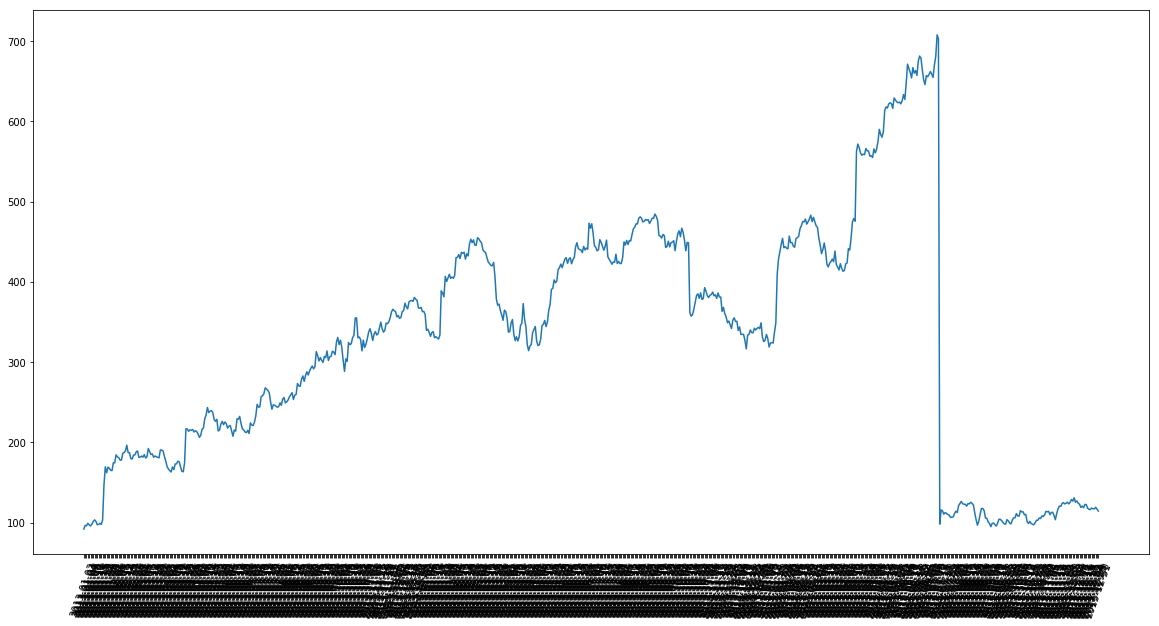

In [6]:
# plotting one dataset for fun
plt.figure(figsize=(20,10))
plt.plot(mydates['NFLX'],myclose['NFLX'])
plt.xticks(rotation=70)
plt.show()

In [7]:
# split in training, validation and test set
def splitting(mydic):
    train_dic = {}
    val_dic ={}
    test_dic = {}
    for key, value in mydic.items():
        dataset = value
        train_size = int(len(dataset) * 0.6)
        val_size = int(len(dataset) * 0.2)
        test_size = len(dataset) - train_size - val_size
        train, val, test = dataset[0:train_size], dataset[train_size:train_size+val_size], dataset[train_size+val_size:len(dataset)]
        train_dic[key] = train
        val_dic[key] = val
        test_dic[key] = test
    return train_dic, val_dic, test_dic

In [8]:
train_dic, val_dic, test_dic = splitting(myclose)

In [9]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)

In [10]:
look_back = input("How many days in the past do you want to use as feature vector? ")
print("You chose: ", look_back)
look_back = int(look_back)

How many days in the past do you want to use as feature vector? 2
You chose:  2


In [11]:
def dictdatasets(mydict, look_back):
    X_dict = {}
    Y_dict = {}
    #pdb.set_trace()
    for key,value in mydict.items():
        dataset = value
        Xdata, Ydata = create_dataset(dataset, look_back)
        X_dict[key] = Xdata
        Y_dict[key] = Ydata
    return X_dict, Y_dict


In [12]:
trainXdict, trainYdict = dictdatasets(train_dic, look_back)
valXdict, valYdict = dictdatasets(val_dic, look_back)
testXdict, testYdict = dictdatasets(test_dic, look_back)

# ML methods to use:
Decision Trees<br>
MLP - Multilayer Perceptron Regressor<br>
SVR - Support Vector Regression<br>
NNR - Nearest Neighbor Regression

In [13]:
# import the needed libraries
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error
from math import sqrt

In [14]:
treeclass = tree.DecisionTreeRegressor()
MLPclass = MLPClassifier(hidden_layer_sizes=(30,30,30),max_iter=10000)
SVRclass = SVR(C=1.0, epsilon=0.2)
neighclass = KNeighborsRegressor(n_neighbors=2)

# Train on all stocks - use for one stock

In [15]:
## choose stock
stocknbr = input("Choose one number for one of the stocks above (starting from 0) ")
stocknbr = int(stocknbr)
print("You chose: ", stocks[stocknbr])

Choose one number for one of the stocks above (starting from 0) 0
You chose:  NFLX


In [16]:
def makebigdataset(mytraindictX,mytraindictY,look_back):
    
    #trainX = np.empty([1,look_back])
    #trainY = np.empty([1])
    for key,value in mytraindictX.items():
        if 'trainX' in locals():
            trainX = np.concatenate((trainX,value))
        else:
            trainX = value
    for key, value in mytraindictY.items():
        if 'trainY' in locals():
            trainY = np.concatenate((trainY,value))
        else:
            trainY = value
    return np.asarray(trainX), np.asarray(trainY)
        
#        train1X = trainXdict[stocks[stocknbr]]
 #       train1Y = trainYdict[stocks[stocknbr]]
  #      val1X = valXdict[stocks[stocknbr]]
   #     val1Y = valYdict[stocks[stocknbr]]
    #    test1X = testXdict[stocks[stocknbr]]
     #   test1Y = testYdict[stocks[stocknbr]]
      #  dataset = myclose[stocks[stocknbr]]
       # thedates = mydates[stocks[stocknbr]]

In [17]:
trainX, trainY = makebigdataset(trainXdict, trainYdict,look_back)
valX, valY = makebigdataset(valXdict, valYdict,look_back)
testX, testY = makebigdataset(testXdict, testYdict,look_back)

In [18]:
len(testX)

745

In [19]:
scaler = StandardScaler()
scaler.fit(trainX)
trainX_MLP = scaler.transform(trainX.astype('|S6'))
trainY_MLP = trainY.astype('|S6')
valX_MLP = scaler.transform(valX.astype('|S6'))
testX_MLP = scaler.transform(testX.astype('|S6'))

/Users/beate/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype |S6 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [20]:
# train the classifiers on the training data
treeclass = treeclass.fit(trainX, trainY)

In [21]:
MLPclass.fit(trainX_MLP,trainY_MLP)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30, 30, 30), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [22]:
SVRclass = SVRclass.fit(trainX, trainY)

In [23]:
neighclass.fit(trainX, trainY) 

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='uniform')

In [24]:
train1X = trainXdict[stocks[stocknbr]]
train1Y = trainYdict[stocks[stocknbr]]
val1X = valXdict[stocks[stocknbr]]
val1Y = valYdict[stocks[stocknbr]]
test1X = testXdict[stocks[stocknbr]]
test1Y = testYdict[stocks[stocknbr]]
dataset = myclose[stocks[stocknbr]]
thedates = mydates[stocks[stocknbr]]

In [25]:
# do predictions for all classifiers
tree_trainPredict = treeclass.predict(train1X)
tree_valPredict = treeclass.predict(val1X)
tree_testPredict = treeclass.predict(test1X)

MLP_trainPredict = MLPclass.predict(train1X)
MLP_valPredict = MLPclass.predict(val1X)
MLP_testPredict = MLPclass.predict(test1X)

SVR_trainPredict = SVRclass.predict(train1X)
SVR_valPredict = SVRclass.predict(val1X)
SVR_testPredict = SVRclass.predict(test1X)

neigh_trainPredict = neighclass.predict(train1X)
neigh_valPredict = neighclass.predict(val1X)
neigh_testPredict = neighclass.predict(test1X)

In [32]:
tree_trainScore = np.sqrt(mean_squared_error(train1Y, tree_trainPredict))
tree_valScore = np.sqrt(mean_squared_error(val1Y, tree_valPredict))
tree_testScore = np.sqrt(mean_squared_error(test1Y, tree_testPredict))
print('Tree Train Score: %.2f RMSE' % (tree_trainScore))
print('Tree Val Score: %.2f RMSE' % (tree_valScore))
print('Tree Test Score: %.2f RMSE' % (tree_testScore))

MLP_trainScore = np.sqrt(mean_squared_error(train1Y, MLP_trainPredict.astype('float32')))
MLP_valScore = np.sqrt(mean_squared_error(val1Y, MLP_valPredict.astype('float32')))
MLP_testScore = np.sqrt(mean_squared_error(test1Y, MLP_testPredict.astype('float32')))
print('MLP Train Score: %.2f RMSE' % (MLP_trainScore))
print('MLP Val Score: %.2f RMSE' % (MLP_valScore))
print('MLP Test Score: %.2f RMSE' % (MLP_testScore))

SVR_trainScore = np.sqrt(mean_squared_error(train1Y, SVR_trainPredict))
SVR_valScore = np.sqrt(mean_squared_error(val1Y, SVR_valPredict))
SVR_testScore = np.sqrt(mean_squared_error(test1Y, SVR_testPredict))
print('SVR Train Score: %.2f RMSE' % (SVR_trainScore))
print('SVR Val Score: %.2f RMSE' % (SVR_valScore))
print('SVR Test Score: %.2f RMSE' % (SVR_testScore))

neigh_trainScore = np.sqrt(mean_squared_error(train1Y, neigh_trainPredict))
neigh_valScore = np.sqrt(mean_squared_error(val1Y, neigh_valPredict))
neigh_testScore = np.sqrt(mean_squared_error(test1Y, neigh_testPredict))
print('neigh Train Score: %.2f RMSE' % (neigh_trainScore))
print('neigh Val Score: %.2f RMSE' % (neigh_valScore))
print('neigh Test Score: %.2f RMSE' % (neigh_testScore))

Tree Train Score: 0.00 RMSE
Tree Val Score: 47.61 RMSE
Tree Test Score: 98.53 RMSE
MLP Train Score: 187.18 RMSE
MLP Val Score: 95.63 RMSE
MLP Test Score: 335.95 RMSE
SVR Train Score: 281.78 RMSE
SVR Val Score: 384.74 RMSE
SVR Test Score: 278.06 RMSE
neigh Train Score: 7.23 RMSE
neigh Val Score: 46.39 RMSE
neigh Test Score: 91.36 RMSE


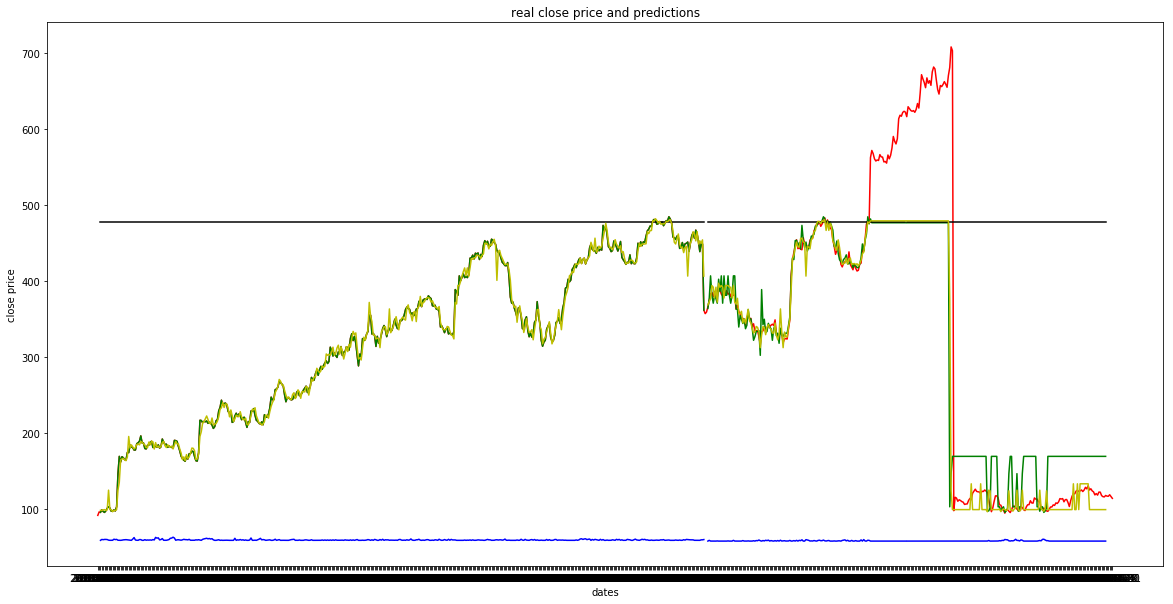

In [28]:
# shift train predictions for plotting
treetrainPredictPlot = np.empty_like(dataset)
treetrainPredictPlot[:] = np.nan
treetrainPredictPlot[look_back:len(tree_trainPredict)+look_back] = tree_trainPredict[:]

MLPtrainPredictPlot = np.empty_like(dataset)
MLPtrainPredictPlot[:] = np.nan
MLPtrainPredictPlot[look_back:len(MLP_trainPredict)+look_back] = MLP_trainPredict[:]

SVRtrainPredictPlot = np.empty_like(dataset)
SVRtrainPredictPlot[:] = np.nan
SVRtrainPredictPlot[look_back:len(SVR_trainPredict)+look_back] = SVR_trainPredict[:]

neightrainPredictPlot = np.empty_like(dataset)
neightrainPredictPlot[:] = np.nan
neightrainPredictPlot[look_back:len(neigh_trainPredict)+look_back] = neigh_trainPredict[:]

# shift val predictions for plotting
treevalPredictPlot = np.empty_like(dataset)
treevalPredictPlot[:] = np.nan
treevalPredictPlot[len(tree_trainPredict)+(look_back*2):len(tree_trainPredict)+len(tree_valPredict)+(look_back*2)] = tree_valPredict[:]

MLPvalPredictPlot = np.empty_like(dataset)
MLPvalPredictPlot[:] = np.nan
MLPvalPredictPlot[len(MLP_trainPredict)+(look_back*2):len(MLP_trainPredict)+len(MLP_valPredict)+(look_back*2)] = MLP_valPredict[:]

SVRvalPredictPlot = np.empty_like(dataset)
SVRvalPredictPlot[:] = np.nan
SVRvalPredictPlot[len(SVR_trainPredict)+(look_back*2):len(SVR_trainPredict)+len(SVR_valPredict)+(look_back*2)] = SVR_valPredict[:]

neighvalPredictPlot = np.empty_like(dataset)
neighvalPredictPlot[:] = np.nan
neighvalPredictPlot[len(neigh_trainPredict)+(look_back*2):len(neigh_trainPredict)+len(neigh_valPredict)+(look_back*2)] = neigh_valPredict[:]

# shift test prediction for plotting

treetestPredictPlot = np.empty_like(dataset)
treetestPredictPlot[:] = np.nan
treetestPredictPlot[len(tree_trainPredict)+len(tree_valPredict)+(look_back*2):len(tree_trainPredict)+len(tree_valPredict)+len(tree_testPredict)+(look_back*2)] = tree_testPredict[:]

MLPtestPredictPlot = np.empty_like(dataset)
MLPtestPredictPlot[:] = np.nan
MLPtestPredictPlot[len(MLP_trainPredict)+len(MLP_valPredict)+(look_back*2):len(MLP_trainPredict)+len(MLP_valPredict)+len(MLP_testPredict)+(look_back*2)] = MLP_testPredict[:]

SVRtestPredictPlot = np.empty_like(dataset)
SVRtestPredictPlot[:] = np.nan
SVRtestPredictPlot[len(SVR_trainPredict)+len(SVR_valPredict)+(look_back*2):len(SVR_trainPredict)+len(SVR_valPredict)+len(SVR_testPredict)+(look_back*2)] = SVR_testPredict[:]

neightestPredictPlot = np.empty_like(dataset)
neightestPredictPlot[:] = np.nan
neightestPredictPlot[len(neigh_trainPredict)+len(neigh_valPredict)+(look_back*2):len(neigh_trainPredict)+len(neigh_valPredict)+len(neigh_testPredict)+(look_back*2)] = neigh_testPredict[:]

# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(thedates,dataset,'r')
plt.plot(thedates,treetrainPredictPlot,'g')
plt.plot(thedates,treevalPredictPlot,'g')
plt.plot(thedates,treetestPredictPlot,'g')
plt.plot(thedates,MLPtrainPredictPlot,'k')
plt.plot(thedates,MLPvalPredictPlot,'k')
plt.plot(thedates,MLPtestPredictPlot,'k')
plt.plot(thedates,SVRtrainPredictPlot,'b')
plt.plot(thedates,SVRvalPredictPlot,'b')
plt.plot(thedates,SVRtestPredictPlot,'b')
plt.plot(thedates,neightrainPredictPlot,'y')
plt.plot(thedates,neighvalPredictPlot,'y')
plt.plot(thedates,neightestPredictPlot,'y')
plt.ylabel('close price')
plt.xlabel('dates')
plt.title('real close price and predictions')
plt.show()

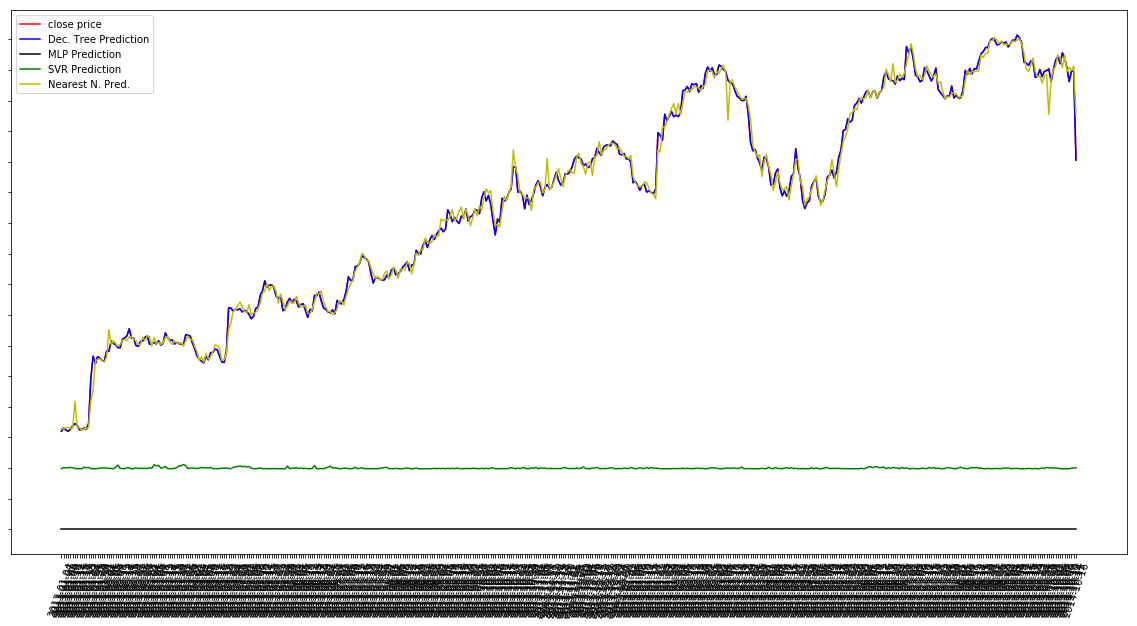

In [29]:
# plot only training
beingsaved = plt.figure(figsize=(20,10))
ax = plt.axes()

datechunk = thedates[look_back:len(tree_trainPredict)+look_back]
datachunk = dataset[look_back:len(tree_trainPredict)+look_back]
plt.plot(datechunk,datachunk,'r')
plt.plot(datechunk,tree_trainPredict,'b')
plt.plot(datechunk,MLP_trainPredict,'k')
plt.plot(datechunk,SVR_trainPredict,'g')
plt.plot(datechunk,neigh_trainPredict,'y')
#plt.xticks(datechunk[1:len(datechunk):500], rotation=70)
plt.xticks(rotation=70)
plt.legend(['close price','Dec. Tree Prediction','MLP Prediction','SVR Prediction','Nearest N. Pred.'])
#ax.xaxis.set_major_locator(plt.MaxNLocator(50))
ax.yaxis.set_major_locator(plt.MaxNLocator(20))
beingsaved.savefig('training_from1stock.eps', format='eps', dpi=1000)

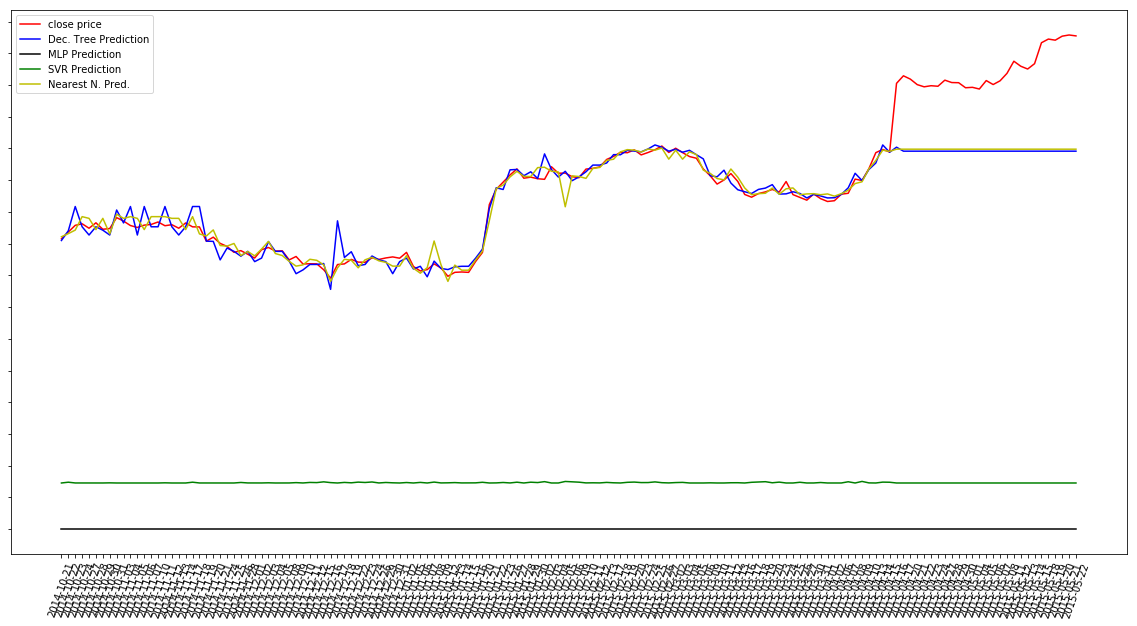

In [30]:
# plot only val
beingsaved = plt.figure(figsize=(20,10))
ax = plt.axes()

datechunk = thedates[len(tree_trainPredict)+(look_back*2):len(tree_trainPredict)+len(tree_valPredict)+(look_back*2)]
datachunk = dataset[len(tree_trainPredict)+(look_back*2):len(tree_trainPredict)+len(tree_valPredict)+(look_back*2)]
plt.plot(datechunk,datachunk,'r')
plt.plot(datechunk,tree_valPredict,'b')
plt.plot(datechunk,MLP_valPredict,'k')
plt.plot(datechunk,SVR_valPredict,'g')
plt.plot(datechunk,neigh_valPredict,'y')
#plt.xticks(datechunk[1:len(datechunk):500], rotation=70)
plt.xticks(rotation=70)
plt.legend(['close price','Dec. Tree Prediction','MLP Prediction','SVR Prediction','Nearest N. Pred.'])
#ax.xaxis.set_major_locator(plt.MaxNLocator(50))
ax.yaxis.set_major_locator(plt.MaxNLocator(20))
beingsaved.savefig('val_from1stock.eps', format='eps', dpi=1000)

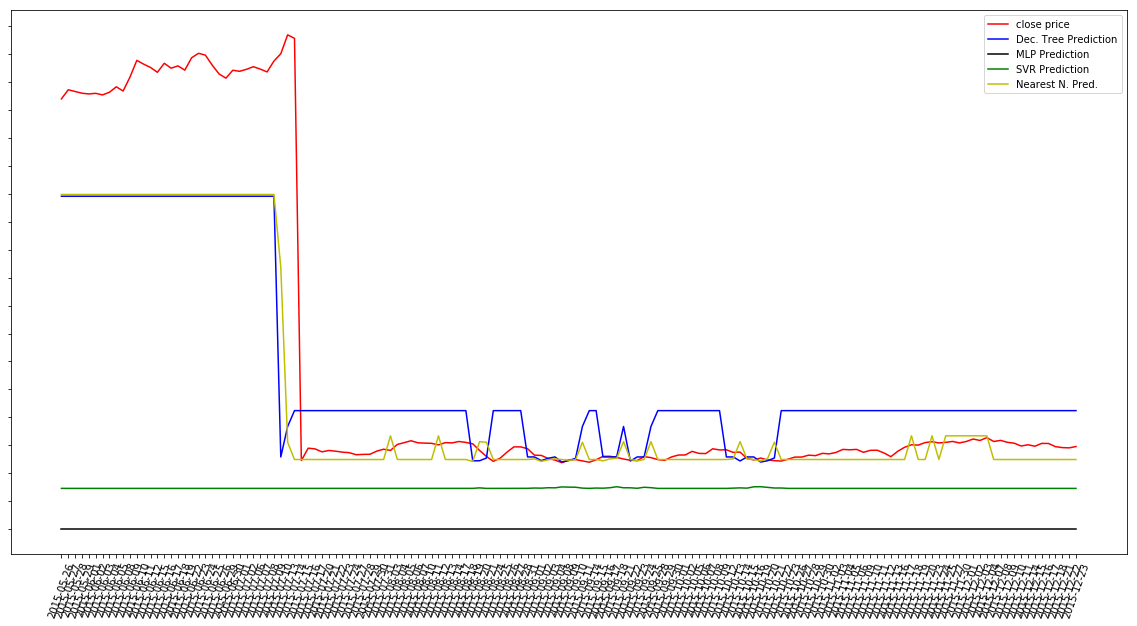

In [31]:
# plot only test
beingsaved = plt.figure(figsize=(20,10))
ax = plt.axes()

datechunk = thedates[len(tree_trainPredict)+len(tree_valPredict)+(look_back*2):len(tree_trainPredict)+len(tree_valPredict)+len(tree_testPredict)+(look_back*2)]
datachunk = dataset[len(tree_trainPredict)+len(tree_valPredict)+(look_back*2):len(tree_trainPredict)+len(tree_valPredict)+len(tree_testPredict)+(look_back*2)]
plt.plot(datechunk,datachunk,'r')
plt.plot(datechunk,tree_testPredict,'b')
plt.plot(datechunk,MLP_testPredict,'k')
plt.plot(datechunk,SVR_testPredict,'g')
plt.plot(datechunk,neigh_testPredict,'y')
#plt.xticks(datechunk[1:len(datechunk):500], rotation=70)
plt.xticks(rotation=70)
plt.legend(['close price','Dec. Tree Prediction','MLP Prediction','SVR Prediction','Nearest N. Pred.'])
#ax.xaxis.set_major_locator(plt.MaxNLocator(50))
ax.yaxis.set_major_locator(plt.MaxNLocator(20))
beingsaved.savefig('test_from1stock.eps', format='eps', dpi=1000)